# Photon Transfer Curve measurements

The Photon Transfer Curve (PTC) method allows measurements of the gain (conversion factor from photoelectrons to DNs) and read noise of a detector. These parameters are essential for both the choice of the acquisition parameters and the reduction of the data.


## Data acquisition

We do not have a reliable way to measure the . We thus assume [reciprocity](https://en.wikipedia.org/wiki/Reciprocity_(photography)) of the sensor, which is true for all practical purposes, and vary the exposure time.

100%|██████████| 23/23 [01:38<00:00,  4.29s/it]


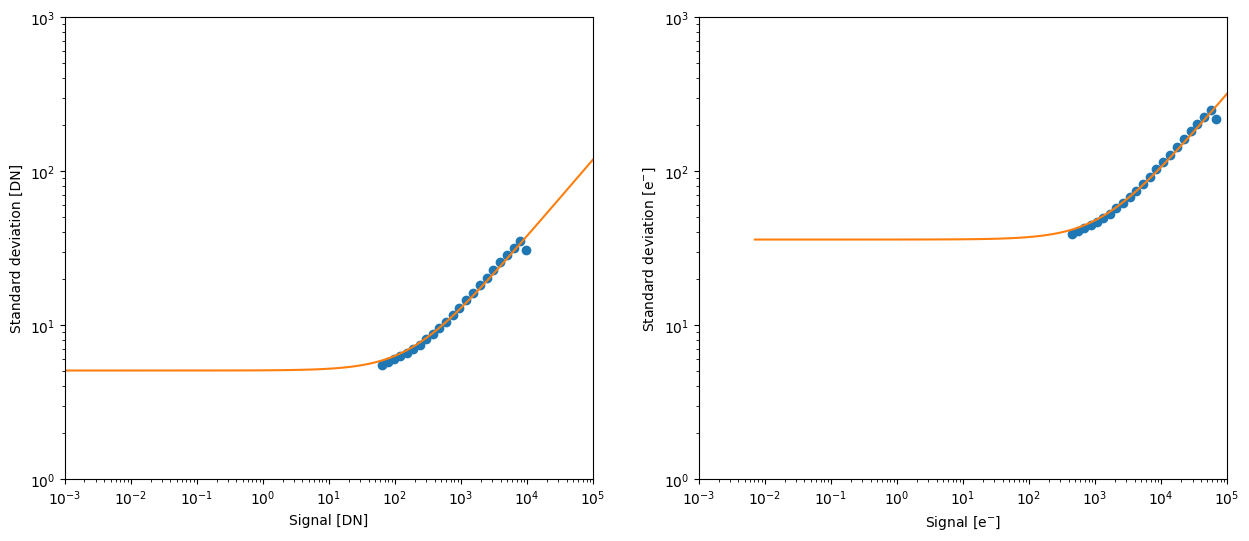

In [3]:
import os
import glob
import numpy as np
from tqdm import tqdm
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from inout import get_headers
from image import Image

def ptc_model(x, g, n):
    return np.sqrt(g * x + n ** 2)

base_path = r'D:\Astro\EOS6D\20180613\PTC_2img\100'

files = glob.glob(os.path.join(base_path, '**', '*.CR2'), recursive=True)

bias_file = r'C:\EOS6D\bias\backup\eos6d_bias_iso00100_20180527.fits'
bias_frame = fits.getdata(bias_file)

# Limit the measurement to a small FOV in case the illumination is not uniform
fov_half_width = 100
fov = tuple([slice(s // 2 - fov_half_width, s // 2 + fov_half_width) for s in bias_frame.shape])

headers = get_headers(files)
# Find the unique occurrences of ISO (gain) values in the headers
unique_gains = list(set([h['ISO'] for h in headers]))  # set is used to remove duplicates
gain_ptc = []
for gain in unique_gains:
    # Find the unique occurrences of EXPTIME (exposure time) values in the headers for the given ISO
    unique_exposure_times = list(set([h['EXPTIME'] for h in headers if h['ISO'] == gain]))
    signal = []  # signal will be stored here
    std = []  # standard deviation will be stored here
    for t in tqdm(unique_exposure_times):
        # Finds the files matching the current ISO and EXPTIME
        matching_files = [f for h, f in zip(headers, files) if h['EXPTIME'] == t and h['ISO'] == gain]
        if len(matching_files) > 1:
            # Read in the data and subtract the bias frame
            image1 = Image(matching_files[0]).data - bias_frame
            image2 = Image(matching_files[1]).data - bias_frame
            # Compute the mean of each bias-subtracted frame
            mean1 = np.mean(image1[fov])
            mean2 = np.mean(image2[fov])
            # Signal is the mean signal in the two frames
            signal.append((mean1 + mean2) / 2)
            # The noise is the standard deviation of the difference.
            # Division by 2 takes into account the fact that the noise is doubled due to the subtraction of 2 images
            std.append(np.sqrt( np.mean( ( (image1 - mean1) - (image2 - mean2) ) ** 2 ) / 2 ))
    signal = np.array(signal)
    std = np.array(std)
    # Fits the standard deviation as a function of the signal withe a model
    p, _ = curve_fit(ptc_model, signal, std, p0=[1, 1], bounds=([0, 0], [1, 100]))

    gain_ptc.append({'signal': signal, 'std': std, 'gain': p[0], 'read_noise': p[1]})

x_lim = 1e-3, 1e5

# For plotting the model
dn_scale = 10 ** (np.log10(x_lim[0]) + np.linspace(0, np.log10(x_lim[1]) - np.log10(x_lim[0]), 100))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for ax, units, gain_norm in zip(axes.flatten(), ['DN', 'e$^{-}$'], [False, True]):
    for ptc, gain in zip(gain_ptc, unique_gains):
        norm = ptc['gain'] if gain_norm else 1
        ax.plot(ptc['signal'] / norm, ptc['std'] / norm, 'o')
        ax.plot(dn_scale / norm, ptc_model(dn_scale, ptc['gain'], ptc['read_noise']) / norm)

    ax.set_xlabel(f'Signal [{units}]')
    ax.set_ylabel(f'Standard deviation [{units}]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(*x_lim)
    ax.set_ylim(1, 1e3)